In [1]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import networkx as nx
import numpy as np
import os
import random
from matplotlib import pyplot as plt

In [2]:
class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

#generate random graph of preset size
def generate_graph(vertices):
    return nx.generators.random_graphs.gnp_random_graph(vertices,
                np.random.uniform(0,0.5))

Naive Game instance - it is possible to remove any node at any state except terminal, even if it has degree zero. An action simply removes adjacent edges to the node, not the node itself.

In [3]:
class NaiveVertexCoverInstance(Node):
    def __init__(self, graph, cover = [], reward = 0):
        self.graph = graph
        self.cover = cover
        self.reward = reward
        
    def find_children(self):
        possiblemoves = []
        if self.is_terminal():  # If the game is finished then no moves can be made
            return possiblemoves
        for i in list(self.graph.nodes):
            H = self.graph.copy()
            step_reward = -1
            H.remove_node(i)
            H.add_node(i)
            possiblemoves.append(VertexCoverInstance(H, self.cover+[i], self.reward+step_reward))
        return possiblemoves

    def take_action(self, action):
        if self.is_terminal():
            raise IndexError("Terminal state cannot be acted upon")
        H = self.graph.copy()
        step_reward = -1
        H.remove_node(action)
        H.add_node(action)
        return VertexCoverInstance(H, self.cover+[action], self.reward+step_reward)

    def find_random_child(self):
        if self.is_terminal():
            return None  # If the game is finished then no moves can be made
        temp = self.find_children()
        return random.sample(set(temp),1)[0]

    def is_terminal(self):
        return nx.classes.function.is_empty(self.graph)

    def to_pretty_string(self):
        return str(list(self.graph.nodes()))

    def get_cover(self):
        return self.cover

    def get_reward(self):
        return self.reward

Vertex Cover Game - Removal only with restricted action space to nodes of positive degree

In [4]:
class VertexCoverInstance(Node):
    def __init__(self, graph, cover = [], reward = 0):
        self.graph = graph
        self.cover = cover
        self.reward = reward
        self.possible_moves = [node for node in list(graph.nodes) if graph.degree[node]]

    def find_children(self):
        possiblemoves = []
        possiblenodes = []
        if self.is_terminal():  # If the game is finished then no moves can be made
            return possiblemoves
        for i in list(self.graph.nodes):
            H = self.graph.copy()
            if H.degree[i]:
                step_reward = -1
                H.remove_node(i)
                H.add_node(i)
                possiblenodes.append(i)
                possiblemoves.append(VertexCoverInstance(H, self.cover+[i], self.reward+step_reward))
        return possiblemoves

    def take_action(self, action):
        if self.is_terminal():
            raise IndexError("Terminal state cannot be acted upon")
        if action not in self.possible_moves:
            raise IndexError("This action is illegal")
        H = self.graph.copy()
        step_reward = -1
        H.remove_node(action)
        H.add_node(action)
        return VertexCoverInstance(H, self.cover+[action], self.reward+step_reward)

    def find_random_child(self):
        if self.is_terminal():
            return None  # If the game is finished then no moves can be made
        temp = self.find_children()
        return random.sample(set(temp),1)[0]

#     def reward(board):
#         if not board.terminal:
#             raise RuntimeError(f"reward called on nonterminal board {board}")
#         return self.reward #reward comes upon reaching terminal state

    def is_terminal(self):
        return nx.classes.function.is_empty(self.graph)

    def to_pretty_string(self):
        return str(list(self.graph.nodes()))

    def get_cover(self):
        return self.cover

    def get_reward(self):
        return self.reward

Game instance where addition and removal are both possible. Terminal state chosen with 30% probability if empty criteria is met.

In [28]:
class VertexCoverAddRemove(Node):
    def __init__(self, graph, cover = [], reward = 0):
        self.init_graph = graph #keeps track of initial graph state (for edge addition)
        self.cover = cover #keeps track of nodes in cover (to construct current graph state)
        self.reward = reward
        self.size = self.init_graph.number_of_nodes()
        self.terminal = False

        #construct current state graph by removing cover edges
        self.graph = self.init_graph.copy()
        if len(cover):
            self.graph.remove_nodes_from(cover)
            self.graph.add_nodes_from(cover)
        
        self.possible_deletions = [node for node in list(self.graph.nodes) if self.graph.degree[node]]
        self.possible_additions = [node+self.init_graph.number_of_nodes() for node in self.cover]
        self.possible_moves = list(self.possible_deletions+self.possible_additions)
        
        #probabalistically determines if the state is terminal
        prob = 0
        if nx.classes.function.is_empty(self.graph):
            prob = np.random.random_sample()
        if prob > 0.7:
            self.terminal = True
        if len(self.possible_moves)==0:
            self.terminal = True


    def find_children(self):
        if self.is_terminal():  # If the game is finished then no moves can be made
            return []
        return [self.take_action(i) for i in self.possible_moves]

    def take_action(self, action):
        if self.is_terminal():
            raise IndexError("Terminal state cannot be acted upon")
        if action not in self.possible_moves:
            raise IndexError("This action is illegal")
        if action >= self.size:
            new_cover = self.cover.copy()
            new_cover.remove(action-self.size)
            return VertexCoverAddRemove(self.init_graph, new_cover, self.reward+1)
        return VertexCoverAddRemove(self.init_graph, self.cover+[action], self.reward-1)

    def find_random_child(self):
        if self.is_terminal():
            return None  # If the game is finished then no moves can be made
        temp = self.find_children()
        return random.sample(set(temp),1)[0]


    def is_terminal(self): #30 percent chance of terminal if condition is satisfied (change for exploitation weight)
        return self.terminal

    def get_cover(self):
        return self.cover

    def get_reward(self):
        return self.reward

In [19]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        #invert_reward = True
        reward = 0
        while True:
            #print(node.to_pretty_string())
            if node.is_terminal():
                return reward
            node = node.find_random_child()
            reward = node.get_reward()

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            #reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


In [7]:
def play_game(G, display = True, game = 'standard', num_rollouts = 50):
    tree = MCTS()
    if game=='standard':
        board = VertexCoverInstance(G)
    elif game=='naive':
        board = NaiveVertexCoverInstance(G)
    elif game=='addremove':
        board = VertexCoverAddRemove(G)
        
    moves = 0
    while True:
        if board.is_terminal():
            break
        #rolls out tree
        for _ in range(num_rollouts):
            tree.do_rollout(board)
        board = tree.choose(board)
        moves = moves+1
        if board.is_terminal():
            break
            
    vc = board.get_cover()
    if display:
        print("\n\nMCTS APPROX\n")
        print(vc)
        color_map = []
        for node in G:
            if node in vc:
                color_map.append('red')
            else: 
                color_map.append('blue')  
        plt.figure(1)
        nx.draw(G, node_color=color_map, with_labels=True)
        
    return vc

In [8]:
from networkx.algorithms import approximation as appx
import itertools

def show_optimal_vc(G, display=True):
    #opt = list(appx.vertex_cover.min_weighted_vertex_cover(G))
    def findsubsets(s): 
        lists =[list(itertools.combinations(s, n)) for n in range(len(s))]
        return list(itertools.chain.from_iterable(lists))
    
    powerset = findsubsets(list(G.nodes()))    
    for s in powerset:
        H = G.copy()
        H.remove_nodes_from(s)
        if nx.classes.function.is_empty(H):
            opt = list(s)
            break
    if display:
        print("\n\nOPTIMAL\n")
        print(opt)
        color_map = []
        for node in G:
            if node in opt:
                color_map.append('orange')
            else: 
                color_map.append('green')
        plt.figure(2)
        nx.draw(G, node_color=color_map, with_labels=True)
        
    return opt



MCTS APPROX

[6, 8, 1, 2, 5]



OPTIMAL

[1, 2, 5, 6, 8]
Finished in 0.44524431228637695 sec


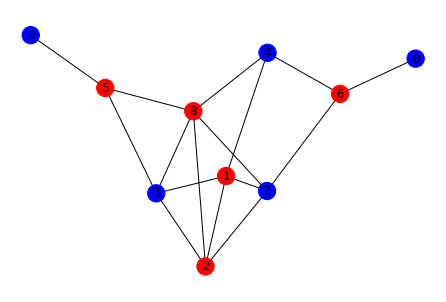

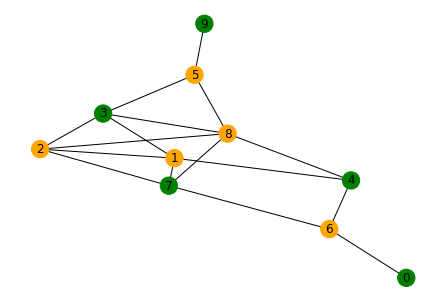

In [40]:
import time
start = time.time()
G = generate_graph(10)
vc = play_game(G,game='naive')
print()
opt = show_optimal_vc(G)

print('Finished in {} sec'.format(time.time()-start))

In [38]:
NUM_SIMS = 1000

def sim_test_approx(simulations):
    naive_count_success = 0
    standard_count_success = 0
    addremove_count_success = 0
    naive_counts = []
    standard_counts = []
    addremove_counts = []
    
    for x in range(simulations):
        A = generate_graph(10)
        vc = play_game(A, display=False, game = 'naive', num_rollouts=80)
        vc2 = play_game(A, display=False, game = 'standard',num_rollouts=80)
        vc3 = play_game(A, display=False, game = 'addremove',num_rollouts=80)
        opt = show_optimal_vc(A, display=False)
        
        if len(vc)<=len(opt)*1.1:
            naive_count_success+=1
        if len(vc2)<=len(opt)*1.1:
            standard_count_success+=1
        if len(vc3)<=len(opt)*1.1:
            addremove_count_success+=1
        naive_counts.append(naive_count_success)
        standard_counts.append(standard_count_success)
        addremove_counts.append(addremove_count_success)
    return np.array(naive_counts), np.array(standard_counts), np.array(addremove_counts),naive_count_success, standard_count_success, addremove_count_success
c1,c2,c3,s1,s2,s3 = sim_test_approx(NUM_SIMS)

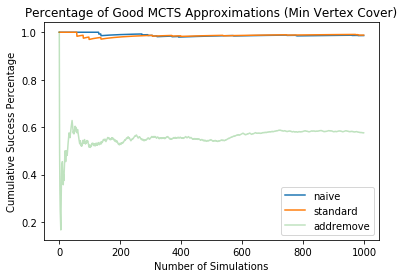

In [39]:
#plot_arr = [successes, NUM_SIMS-successes]
plt.figure(3)
#plt.pie(plot_arr, colors = ['lightcoral','lightskyblue'], labels = ['good approx', 'bad approx'],autopct='%1.2f%%')
plt.plot(c1/np.array(range(1,NUM_SIMS+1)))
plt.plot(c2/np.array(range(1,NUM_SIMS+1)))
plt.plot(c3/np.array(range(1,NUM_SIMS+1)), alpha=0.3)
plt.legend(['naive','standard','addremove'])
plt.xlabel('Number of Simulations')
plt.ylabel('Cumulative Success Percentage')
plt.title('Percentage of Good MCTS Approximations (Min Vertex Cover)')
plt.show()

In [29]:
NUM_SIMS = 100
rollouts = range(3,31,3)

naive_scores = []
standard_scores = []
addremove_scores = []

def sim_test_approx(simulations, rollouts):
    naive_count_success = 0
    standard_count_success = 0
    addremove_count_success = 0
    
    for x in range(simulations):
        A = generate_graph(10)
        vc = play_game(A, display=False, game = 'naive',num_rollouts=rollouts)
        vc2 = play_game(A, display=False, game='standard', num_rollouts=rollouts)
        vc3 = play_game(A, display=False, game = 'addremove',num_rollouts=rollouts)
        opt = show_optimal_vc(A, display=False)
        
        if len(vc)<=len(opt)*1.1:
            naive_count_success+=1
        if len(vc2)<=len(opt)*1.1:
            standard_count_success+=1
        if len(vc3)<=len(opt)*1.1:
            addremove_count_success+=1
            
    naive_scores.append(naive_count_success/simulations)
    standard_scores.append(standard_count_success/simulations)
    addremove_scores.append(addremove_count_success/simulations)

for rollout in rollouts:
    sim_test_approx(NUM_SIMS, rollout)

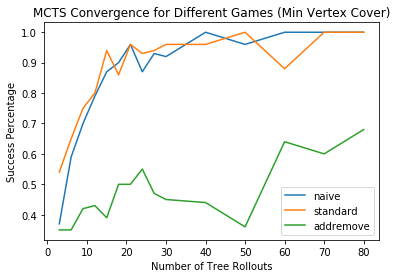

In [37]:
#plot_arr = [successes, NUM_SIMS-successes]
plt.figure(4)
#plt.pie(plot_arr, colors = ['lightcoral','lightskyblue'], labels = ['good approx', 'bad approx'],autopct='%1.2f%%')
plt.plot(rollouts, naive_scores)
plt.plot(rollouts,standard_scores)
plt.plot(rollouts,addremove_scores)
plt.legend(['naive','standard','addremove'])
plt.xlabel('Number of Tree Rollouts')
plt.ylabel('Success Percentage')
plt.title('MCTS Convergence for Different Games (Min Vertex Cover)')
plt.show()

In [36]:
# rollouts = list(rollouts) + list(range(40,81,10))
# print(rollouts)
for rollout in range(40,81,10):
    sim_test_approx(25, rollout)